In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import chex
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any, Dict
from flax.training.train_state import TrainState
import distrax

from jaxmarl import make
from jaxmarl.wrappers.baselines import (
    SMAXLogWrapper,
    MPELogWrapper,
    LogWrapper,
    CTRolloutManager,
)
from jaxmarl.environments.smax import map_name_to_scenario, HeuristicEnemySMAX
from jaxmarl.viz.visualizer import Visualizer, SMAXVisualizer

import functools
from functools import partial
import time
import os
import matplotlib.pyplot as plt

from qdax.core.map_elites import MAPElites
from qdax.core.containers.mapelites_repertoire import compute_cvt_centroids, MapElitesRepertoire
#import qdax.tasks.brax.v1 as environments
#from qdax.tasks.brax.v1.env_creators import scoring_function_brax_envs as scoring_function
from qdax.core.neuroevolution.buffers.buffer import QDTransition
from qdax.core.neuroevolution.networks.networks import MLP
from qdax.core.emitters.mutation_operators import isoline_variation
from qdax.core.emitters.standard_emitters import MixingEmitter
from qdax.utils.plotting import plot_map_elites_results
from qdax.utils.metrics import CSVLogger, default_qd_metrics



from dataclasses import dataclass

from qdax.core.emitters.repertoire_selectors.selector import Selector
from qdax.core.emitters.qpg_emitter import QualityPGConfig, QualityPGEmitterState
from qdax.tasks.brax.v1.envs.base_env import QDEnv

from qdax.core.emitters.multi_emitter import MultiEmitter
from qdax.core.containers.ga_repertoire import GARepertoire
from qdax.core.containers.repertoire import Repertoire
#from qdax.core.neuroevolution.losses.td3_loss import make_td3_loss_fn
from qdax.core.emitters.emitter import Emitter
#from qdax.core.neuroevolution.networks.networks import QModule
#from qdax.core.neuroevolution.buffers.buffer import ReplayBuffer

from qdax.core.emitters.pga_me_emitter import PGAMEConfig, PGAMEEmitter

import flashbax as fbx
## Brax version conflict with JaxMARL(0.10.3) and QDax(0.10.4 / 0.12.3)

In [2]:
from typing import Callable, Optional, Tuple
from qdax.custom_types import (
    Action,
    Descriptor,
    EnvState,
    ExtraScores,
    Fitness,
    Genotype,
    Observation,
    Params,
    RNGKey,
)

In [3]:
config = {
    # valid for iql, vdn, qmix
    "TOTAL_TIMESTEPS": 1e7, #1e7,
    "NUM_ENVS": 4, #16,
    "NUM_STEPS": 128,
    "BUFFER_SIZE": 10000, #5000,
    "BUFFER_BATCH_SIZE": 32,
    "HIDDEN_SIZE": 64, #128, #512,
    "MIXER_EMBEDDING_DIM": 16, #64,
    "MIXER_HYPERNET_HIDDEN_DIM": 64, #256,
    "MIXER_INIT_SCALE": 0.001,
    "EPS_START": 1.0,
    "EPS_FINISH": 0.05,
    "EPS_DECAY": 0.1, # percentage of updates
    "MAX_GRAD_NORM": 10,
    "TARGET_UPDATE_INTERVAL": 10, #10,
    "TAU": 1., #1.,
    "NUM_EPOCHS": 8,
    "LR": 0.00005,
    "LEARNING_STARTS": 10000, # timesteps
    "LR_LINEAR_DECAY": False,
    "GAMMA": 0.99,
    "REW_SCALE": 10., # scale the reward to the original scale of SMAC

    # ENV
    "ENV_NAME": "HeuristicEnemySMAX",
    #"MAP_NAME": "3s_vs_5z",
    #"MAP_NAME":"smacv2_5_units", # 5 random units for each size
    "MAP_NAME": "2s3z",
    "ENV_KWARGS": {
        "see_enemy_actions": True,
        "walls_cause_death": True,
        "attack_mode": "closest",
        #"won_battle_bonus": 10.0, # To test if increasing winning reward gets solution to beat enemy
    },

    "NUM_SEEDS": 1, # number of vmapped seeds (not used)
    "SEED": 88,

    "HYP_TUNE": False, # perform hyp tune

    # evaluate
    "TEST_DURING_TRAINING": False, #True,
    "TEST_INTERVAL": 0.05, # as a fraction of updates, i.e. log every 5% of training process
    "TEST_NUM_STEPS": 128,
    "TEST_NUM_ENVS": 512, # number of episodes to average over, can affect performance
}
batch_size = 20# 128 # Num of offsprings 
#env_name = 'walker2d_uni'
episode_length = config["NUM_STEPS"] #128  # NUM_STEPS
num_iterations = int(config["TOTAL_TIMESTEPS"] / (batch_size * config["NUM_ENVS"] * config["NUM_STEPS"]))
seed = 88 
policy_hidden_layer_sizes = (128, 128, 128) #(64, 64)
iso_sigma = 0.05 #0.005 
line_sigma = 0.5 #0.05 
num_init_cvt_samples = 20000 #50000 
num_centroids = 1024 #1024 
min_descriptor = 0. 
max_descriptor = 1.0 
number_of_descriptors=2


proportion_mutation_ga = 0.5 

# IQL/TD3 params
env_batch_size = batch_size #100 
replay_buffer_size = config["BUFFER_SIZE"] #1000000 
critic_hidden_layer_size = (256, 256) 
critic_learning_rate = 3e-4 
greedy_learning_rate = 3e-4 
policy_learning_rate = 1e-3 
noise_clip = 0.5
policy_noise = 0.2 
discount = config["GAMMA"] #0.99 
reward_scaling = 1.0 
transitions_batch_size = config["BUFFER_BATCH_SIZE"] #256 
soft_tau_update = 0.005
num_critic_training_steps = 300 
num_pg_training_steps = 10 #100 
policy_delay = 2


@dataclass
class SacConfig:
    """Configuration for the SAC algorithm."""
    batch_size: int = 20
    episode_length: int = 128
    tau: float = 0.005
    learning_rate: float = 3e-5
    normalize_observations: bool = False
    alpha_init: float = 0.05
    discount: float = 0.97
    entropy_coef: float = 0.5
    clip: float = 0.1
    reward_scaling: float = 0.1
    critic_hidden_layer_size: tuple = (256, 256)
    policy_hidden_layer_size: tuple = (256, 256)
    fix_alpha: bool = False


# Define the PG-emitter config
@dataclass
class CustomPGAMEConfig(PGAMEConfig):
    num_envs: Any = None
    num_steps: Any = None
    target_update_interval: Any = None
    tau: Any = None

pga_emitter_config = CustomPGAMEConfig(
    env_batch_size=env_batch_size,
    batch_size=transitions_batch_size,
    proportion_mutation_ga=proportion_mutation_ga,
    critic_hidden_layer_size=critic_hidden_layer_size,
    critic_learning_rate=critic_learning_rate,
    greedy_learning_rate=greedy_learning_rate,
    policy_learning_rate=policy_learning_rate,
    noise_clip=noise_clip,
    policy_noise=policy_noise,
    discount=discount,
    reward_scaling=reward_scaling,
    replay_buffer_size=replay_buffer_size,
    soft_tau_update=soft_tau_update,
    num_critic_training_steps=num_critic_training_steps,
    num_pg_training_steps=num_pg_training_steps,
    policy_delay=policy_delay,

    num_envs = config["NUM_ENVS"],
    num_steps = config["NUM_STEPS"],
    target_update_interval = config["TARGET_UPDATE_INTERVAL"],
    tau = config["TAU"],
)


In [4]:
class ScannedRNN(nn.Module):

    @partial(
        nn.scan,
        variable_broadcast="params",
        in_axes=0,
        out_axes=0,
        split_rngs={"params": False},
    )
    @nn.compact
    def __call__(self, carry, x):
        """Applies the module."""
        rnn_state = carry
        ins, resets = x
        hidden_size = ins.shape[-1]
        rnn_state = jnp.where(
            resets[:, np.newaxis],
            self.initialize_carry(hidden_size, *ins.shape[:-1]),
            rnn_state,
        )
        new_rnn_state, y = nn.GRUCell(hidden_size)(rnn_state, ins)
        return new_rnn_state, y

    @staticmethod
    def initialize_carry(hidden_size, *batch_size):
        # Use a dummy key since the default state init fn is just zeros.
        return nn.GRUCell(hidden_size, parent=None).initialize_carry(
            jax.random.PRNGKey(0), (*batch_size, hidden_size)
        )


class RNNQNetwork(nn.Module):
    # homogenous agent for parameters sharing, assumes all agents have same obs and action dim
    action_dim: int
    hidden_dim: int
    init_scale: float = 1.0

    @nn.compact
    def __call__(self, hidden, obs, dones):
        embedding = nn.Dense(
            self.hidden_dim,
            kernel_init=orthogonal(self.init_scale),
            bias_init=constant(0.0),
        )(obs)
        embedding = nn.relu(embedding)

        rnn_in = (embedding, dones)
        hidden, embedding = ScannedRNN()(hidden, rnn_in)

        q_vals = nn.Dense(
            self.action_dim,
            kernel_init=orthogonal(self.init_scale),
            bias_init=constant(0.0),
        )(embedding)

        return hidden, q_vals
    

class RNNActor(nn.Module):
    action_dim: int
    hidden_dim: int
    init_scale: float = 1.0

    @nn.compact
    def __call__(self, hidden, obs, dones, avail_actions):
        embedding = nn.Dense(
            self.hidden_dim,
            kernel_init=orthogonal(self.init_scale),
            bias_init=constant(0.0),
        )(obs)
        embedding = nn.relu(embedding)

        rnn_in = (embedding, dones)
        hidden, embedding = ScannedRNN()(hidden, rnn_in)

        logits = nn.Dense(
            self.action_dim,
            kernel_init=orthogonal(self.init_scale),
            bias_init=constant(0.0),
        )(embedding)

        # Mask out unavailable actions
        unavail_actions = 1 - avail_actions
        masked_logits = logits - (unavail_actions * 1e10)

        return hidden, masked_logits



class RNNCritic(nn.Module):
    action_dim: int
    hidden_dim: int
    n_critics: int = 2

    @nn.compact
    def __call__(self, hidden, obs, dones):

        res = []
        for i in range(self.n_critics):
            embedding = nn.Dense(
                self.hidden_dim,
                kernel_init=orthogonal(np.sqrt(2)),
                bias_init=constant(0.0),
            )(obs)
            embedding = nn.relu(embedding)
            
            rnn_in = (embedding, dones)
            hidden, embedding = ScannedRNN(name=f"rnn_{i}")(hidden, rnn_in) # name each instance of ScannedRNN to keep it different in each critic

            q = nn.Dense(
                self.action_dim, 
                kernel_init=orthogonal(1.0), 
                bias_init=constant(0.0)
            )(embedding)

            res.append(q)

        return jnp.concatenate(res, axis=-1)


In [5]:
#class Transition(NamedTuple):
#    global_done: jnp.ndarray
#    done: jnp.ndarray
#    action: jnp.ndarray
#    reward: jnp.ndarray
#    obs: jnp.ndarray
#    env_state: jnp.ndarray
#    info: jnp.ndarray
#    avail_actions: jnp.ndarray

class Transition(NamedTuple):
    #global_done: jnp.ndarray
    #reward: jnp.ndarray
    env_state: jnp.ndarray
    infos: jnp.ndarray

@chex.dataclass(frozen=True)
class Timestep:
    obs: dict
    next_obs: dict
    actions: dict
    rewards: dict
    dones: dict
    avail_actions: dict
    entropy: jnp.ndarray

class CustomTrainState(TrainState):
    target_network_params: Any
    timesteps: int = 0
    n_updates: int = 0
    grad_steps: int = 0


In [6]:
from brax.training.distribution import ParametricDistribution

class CategoricalDistribution:
  """Categorical distribution"""

  def __init__(self, logits):
    self.logits = logits
    self.probs = jax.nn.softmax(logits, axis=-1)

  def sample(self, seed):
    return jax.random.categorical(seed, self.logits, axis=-1)

  def mode(self):
    return jnp.argmax(self.probs, axis=-1)

  def log_prob(self, action):
    #x_one_hot = jax.nn.one_hot(x, self.logits.shape[-1])
    log_probs = jax.nn.log_softmax(self.logits, axis=-1)
    #return jnp.sum(x_one_hot * log_probs, axis=-1)
    return log_probs
    

  def entropy(self):
    log_probs = jax.nn.log_softmax(self.logits, axis=-1)
    return jnp.expand_dims(-jnp.sum(self.probs * log_probs, axis=-1), -1)


class IdentityBijector:
  """Identity bijector for discrete distributions."""

  def forward(self, x):
    return x

  def inverse(self, y):
    return y

  def forward_log_det_jacobian(self, x):
    return 0.0


class CategoricalParametricDistribution(ParametricDistribution):
  def __init__(self, num_classes: int):
    super().__init__(
      param_size=num_classes,
      postprocessor=IdentityBijector(),
      event_ndims=0,
      reparametrizable=False,
    )

  def create_dist(self, parameters):
    # parameters: [..., num_classes] logits
    return CategoricalDistribution(parameters)

In [7]:
# Init environment
#env = environments.create(env_name, episode_length=episode_length)
scenario = map_name_to_scenario(config["MAP_NAME"])
env = HeuristicEnemySMAX(scenario=scenario, **config["ENV_KWARGS"])
env = SMAXLogWrapper(env)
wrapped_env = CTRolloutManager(env, batch_size=config["NUM_ENVS"])

rng = jax.random.PRNGKey(config["SEED"])
reset_fn = jax.jit(wrapped_env.batch_reset)
#reset_fn = jax.jit(env.reset)

config["NUM_ACTORS"] = env.num_agents * config["NUM_ENVS"]
config["NUM_UPDATES"] = (
    config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
)


# Init a random key
key = jax.random.key(seed)

# Init policy network
#policy_layer_sizes = policy_hidden_layer_sizes + (env.action_space(env.agents[0]).n,) # Not actually used
#policy_network = ActorRNN(env.action_space(env.agents[0]).n, config=config)
policy_network = RNNActor(
            action_dim=wrapped_env.max_action_space,
            hidden_dim=config["HIDDEN_SIZE"],
        )

# Init population of controllers
key, subkey = jax.random.split(key)
#keys = jax.random.split(subkey, num=batch_size)
# fake_batch = jnp.zeros(shape=(batch_size, env.observation_size)) # Not needed as on-policy is used for no batches?
# init_variables = jax.vmap(policy_network.init)(keys, fake_batch)
#init_x = (
#    jnp.zeros(
#        (1, 1, wrapped_env.obs_size)
#    ),  # (time_step, batch_size, obs_size)
#    jnp.zeros((1, 1)),  # (time_step, batch size)
#)
init_x = (
    jnp.zeros(
        (1, 1, wrapped_env.obs_size)
    ),
    jnp.zeros((1, 1)),
    jnp.zeros((1, 1, env.action_space(env.agents[0]).n)),
)
init_hstate = ScannedRNN.initialize_carry(
    config["HIDDEN_SIZE"], 1
)  # (batch_size, hidden_dim)

keys = jax.random.split(subkey, batch_size)
# Assume init_hstate: [H], init_x: [X]
fake_hstate = jnp.stack([init_hstate] * batch_size)  # [N, H]
#fake_x = jnp.stack([init_x] * config["NUM_ENVS"])            # [N, X]
fake_x = tuple(jnp.stack([x] * batch_size) for x in init_x)

#network_params = policy_network.init(subkey, init_hstate, init_x)
network_params = jax.vmap(
    policy_network.init
)(keys, fake_hstate, *fake_x)

# Distribution used for selecting action
dist = CategoricalParametricDistribution(num_classes=env.action_space(env.agents[0]).n)

In [8]:
def batchify(x: dict):
    return jnp.stack([x[agent] for agent in env.agents], axis=0)

def unbatchify(x: jnp.ndarray):
    return {agent: x[i] for i, agent in enumerate(env.agents)}

In [ ]:
def select_action(
    hstate: jnp.array,
    obs: Observation,
    dones: jnp.array,
    avail_actions: jnp.array,
    policy_params: Params,
    key: RNGKey,
    deterministic: bool = False,
) -> Action:
    """Selects an action according to SAC policy.

    Args:
        obs: agent observation(s)
        policy_params: parameters of the agent's policy
        key: jax random key
        deterministic: whether to select action in a deterministic way.
            Defaults to False.

    Returns:
        The selected action and entropy of action distribution.
    """
    #print("obs shape inside select_action:", obs.shape)
    #print("hstate shape inside select_action:", hstate.shape)
    #print("dones shape inside select_action:", dones.shape)
    #print("avail_actions shape inside select_action:", avail_actions.shape)
    
    #logits = policy_network.apply(policy_params, hstate, obs, dones, avail_actions)
    new_hstate, logits = jax.vmap(
        policy_network.apply, in_axes=(None, 0, 0, 0, 0)
    )(  # vmap across the agent dim
        policy_params,
        hstate,
        obs,
        dones,
        avail_actions,
    )
    #print("logits shape inside select_action:", logits.shape)
    if not deterministic:
        actions = dist.sample(logits, key)

    else:
        actions = jnp.argmax(logits, axis=-1)
    
    actions = actions.squeeze(1)  # From (B, 1, A) → (B, A)
    #print("actions shape inside select_action:", actions.shape)
    #print("new_hstate shape inside select_action:", new_hstate.shape)
    
    entropy = dist.entropy(logits, key)
    entropy = jnp.squeeze(entropy)
    #jax.debug.print("action{}".format(actions))
    #print("entropy shape inside select_action:", entropy.shape)


    return new_hstate, actions, entropy

In [10]:
# Define the function to play a step with the policy in the environment
def play_step_fn(
    runner_state
):
    """
    Play an environment step and return the updated state and the transition.
    """
    #hs, last_obs, last_dones, env_state, rng = carry
    policy_params, env_state, last_obs, last_dones, hstate, key = runner_state

    key, key_a, key_s = jax.random.split(key, 3)

    # (num_agents, 1 (dummy time), num_envs, obs_size)
    _obs = batchify(last_obs)[:, np.newaxis]
    _dones = batchify(last_dones)[:, np.newaxis]
    #_obs = batchify_multi(last_obs)[:, :, np.newaxis]    # [batch, num_agents, 1, num_envs, obs_dim]
    #_dones = batchify_multi(last_dones)[:, :, np.newaxis] # [batch, num_agents, 1, num_envs]

    #print("hstate shape:", hstate.shape)  # should be [BATCH_SIZE, NUM_ENVS, NUM_AGENTS, HIDDEN_SIZE]
    #print("_obs shape:", _obs.shape)      # should be [BATCH_SIZE, NUM_ENVS, OBS_DIM]
    #print("_dones shape:", _dones.shape)  # should be [BATCH_SIZE, NUM_ENVS, OBS_DIM]
    
    avail_actions = wrapped_env.get_valid_actions(env_state.env_state)
    avail_actions_batchified = batchify(avail_actions)

    #new_hstate, logits = jax.vmap(
    #    policy_network.apply, in_axes=(None, 0, 0, 0)
    #)(  # vmap across the agent dim
    #    policy_params['agent'],
    #    hstate,
    #    _obs,
    #    _dones,
    #    avail_actions_batchified,
    #)
    #print("new_hstate shape:", new_hstate.shape)  # should be [BATCH_SIZE, NUM_ENVS, NUM_AGENTS, HIDDEN_SIZE]
    
    new_hstate, actions, entropy = select_action(
        hstate = hstate,
        obs=_obs,
        dones=_dones,
        avail_actions=avail_actions_batchified,
        policy_params=policy_params,
        key=key_a,
        deterministic=True,
    )
    actions_dict = unbatchify(actions)

    #q_vals = q_vals.squeeze(
    #    axis=1
    #)  # (num_agents, num_envs, num_actions) remove the time dim


    #eps = eps_scheduler(train_state.n_updates)
    #_rngs = jax.random.split(rng_a, env.num_agents)
    #actions = jax.vmap(eps_greedy_exploration, in_axes=(0, 0, None, 0))(
    #    _rngs, q_vals, eps, batchify(avail_actions)
    #)
    
    #unavail_actions = 1 - avail_actions_batchified
    #q_vals = q_vals - (unavail_actions * 1e10)
    #actions_array = jnp.argmax(q_vals, axis=-1)
    #actions_dict = unbatchify(actions_array)
    #print("actions", actions_dict)

    #print("keys shape: {}", key_s.shape)
    #print("states shape: {}", jax.tree.map(lambda x: x.shape, env_state))
    #print("actions_dict shapes: {}", {k: v.shape for k, v in actions_dict.items()})


    new_obs, new_env_state, rewards, dones, infos = wrapped_env.batch_step(
        key_s, env_state, actions_dict
    )
    
    rewards = jax.tree.map(lambda x:config["REW_SCALE"]*x, rewards)

    timestep = Timestep(
        obs=last_obs,
        next_obs = new_obs,
        actions=actions_dict,
        rewards=rewards, #jax.tree.map(lambda x:config.get("REW_SCALE", 1)*x, rewards),
        dones=last_dones,
        avail_actions=avail_actions,
        entropy = entropy,
    )

    #per_agent_dones = jnp.stack(
    #    [dones[agent] for agent in env.agents], axis=-1
    #)  # shape: [num_envs, num_agents]

    transition = Transition(
        #jnp.tile(dones["__all__"], env.num_agents),
        #last_dones,
        #actions_array.squeeze(),
        #batchify(rewards).reshape(-1),#.reshape(batch_size, config["NUM_ENVS"], -1),  #batchify(rewards, env.agents, config["NUM_ACTORS"]).squeeze(),
        #_obs,
        env_state.env_state.state,
        infos,
        #avail_actions,
    )

    runner_state = (policy_params, new_env_state, new_obs, dones, new_hstate, key)
    
    return runner_state, (transition, timestep)

In [11]:
def generate_unroll(
    runner_state,
    episode_length: int,
    play_step_fn: Callable[
        [EnvState, Params, RNGKey],
        Tuple[
            EnvState,
            Params,
            RNGKey,
            Transition,
        ],
    ],
) -> Tuple[EnvState, Transition]:
    """Generates an episode according to the agent's policy, returns the final state of
    the episode and the transitions of the episode.

    Args:
        init_state: first state of the rollout.
        policy_params: params of the individual.
        key: random key for stochasiticity handling.
        episode_length: length of the rollout.
        play_step_fn: function describing how a step need to be taken.

    Returns:
        A new state, the experienced transition.
    """

    def _scan_play_step_fn(
        carry, unused_arg: Any #: Tuple[EnvState, Params, RNGKey]
    ) -> Tuple[Tuple[EnvState, Params, RNGKey], Transition]:
        runner_state, (transitions, timestep) = play_step_fn(carry)
        return runner_state, (transitions, timestep)

    runner_state, (transitions, timestep) = jax.lax.scan(
        _scan_play_step_fn,
        runner_state,
        (),
        length=episode_length,
    )
    return runner_state, (transitions, timestep)

In [12]:
def scoring_function(
    policy_params: Genotype,
    key: RNGKey,
    episode_length: int,
    play_reset_fn: Callable[[RNGKey], EnvState],
    play_step_fn: Callable[
        [EnvState, Params, RNGKey], Tuple[EnvState, Params, RNGKey, QDTransition]
    ],
    descriptor_extractor: Callable[[QDTransition, jnp.ndarray], Descriptor],
) -> Tuple[Fitness, Descriptor, ExtraScores]:
    """Evaluates policies contained in policies_params in parallel.
    The play_reset_fn function allows for a more general scoring_function that can be
    called with different batch-size and not only with a batch-size of the same
    dimension as init_states.

    To define purely stochastic environments, using the reset function from the
    environment, use "play_reset_fn = env.reset".

    To define purely deterministic environments, as in "scoring_function", generate
    a single init_state using "init_state = env.reset(key)", then use
    "play_reset_fn = lambda key: init_state".

    Args:
        policies_params: The parameters of closed-loop controllers/policies to evaluate.
        key: A jax random key
        episode_length: The maximal rollout length.
        play_reset_fn: The function to reset the environment and obtain initial states.
        play_step_fn: The function to play a step of the environment.
        descriptor_extractor: The function to extract the descriptor.

    Returns:
        fitness: Array of fitnesses of all evaluated policies
        descriptor: Behavioural descriptors of all evaluated policies
        extra_scores: Additional information resulting from the evaluation
    """

    # Reset environments
    key, subkey = jax.random.split(key)
    #keys = jax.random.split(subkey, jax.tree.leaves(policies_params)[0].shape[0])
    #keys = jax.random.split(subkey, config["NUM_ENVS"])
    #init_obs, init_env_state = jax.vmap(play_reset_fn, in_axes=(0,))(keys)
    init_obs, init_env_state = play_reset_fn(key)
    #print("init_obs is a dict with keys:", init_obs.keys())
    #for k, v in init_obs.items():
    #    print(f"init_obs[{k}] shape:", v.shape) 
    
    keys = jax.random.split(subkey, batch_size)

    #init_dones = {
    #    agent: jnp.zeros((config["NUM_ENVS"]), dtype=bool)
    #    for agent in env.agents + ["__all__"]
    #}
    init_hstate = ScannedRNN.initialize_carry(
        config["HIDDEN_SIZE"], len(env.agents), config["NUM_ENVS"]
    )
    
    batched_env_state = jax.tree.map(lambda x: jnp.stack([x] * batch_size), init_env_state)
    batched_obs = jax.tree.map(lambda x: jnp.stack([x] * batch_size), init_obs)
    batched_dones = {
        agent: jnp.stack([jnp.zeros(config["NUM_ENVS"], dtype=bool)] * batch_size)
        for agent in env.agents + ["__all__"]
    }
    batched_hstate = jnp.stack([init_hstate] * batch_size)

    #print("batched_obs is a dict with keys:", batched_obs.keys())
    #for k, v in batched_obs.items():
    #    print(f"batched_obs[{k}] shape:", v.shape) 

    init_runner_state = (policy_params, batched_env_state, batched_obs, batched_dones, batched_hstate, keys)
    #print("init_runner_state:")
    #jax.tree.map(lambda x: print(x.shape), init_runner_state)
    
    # Step environments
    unroll_fn = functools.partial(
        generate_unroll,
        episode_length=episode_length,
        play_step_fn=play_step_fn,
    )
    #keys = jax.random.split(key, jax.tree.leaves(policies_params)[0].shape[0])
    _, (data, timestep) = jax.vmap(unroll_fn)(init_runner_state) # data = Transistions data struc
    #jax.debug.print("after vmap timestep shape: {}", 
    #jax.tree.map(lambda x: x.shape, timestep))

    # Create a mask to extract data properly
    #mask = get_mask_from_transitions(data)
    mask = data.infos["returned_episode"]

    # Evaluate
    #print("data.reward shape:", data.reward.shape)
    #print("data.global_done shape:", data.global_done.shape)
    #print("mask shape:", mask.shape)
    
    #print(type(data.infos["returned_episode_returns"]))
    #print(data.infos["returned_episode_returns"].shape)
    returns = data.infos["returned_episode_returns"][:, :, 0, 0]  # (100, 128)
    done_mask = data.infos["returned_episode"][:, :, 0, 0]       # (100, 128), bool mask

    # Sum returns over completed episodes
    sum_returns = jnp.sum(returns * done_mask, axis=1)  # (100,)

    # Count completed episodes (avoid div by zero)
    num_completed = jnp.sum(done_mask, axis=1)          # (100,)
    num_completed = jnp.maximum(num_completed, 1)

    # Average returns per batch, keep trailing dim
    fitnesses = (sum_returns / num_completed)[:, None]  # (100, 1)
    
    descriptors = descriptor_extractor(data, mask)

    #print("fitness shape:", fitnesses.shape)
    #print("descriptors shape:", descriptors.shape)

    return fitnesses, descriptors, {"transitions": timestep}#data}

In [13]:
def compute_descriptors(data, full_mask):
    """
    Compute per-trajectory descriptors:
    - % of actions that were movement actions over the whole episode (per batch item)
    - Avg ally-ally distance averaged over all steps (per batch item)

    Output: shape (batch_size, 2)
    """
    movement_actions = data.env_state.prev_movement_actions          # (B, T, E, A, 2)
    attack_actions = data.env_state.prev_attack_actions              # (B, T, E, A)
    alive = data.env_state.unit_alive.astype(jnp.float32)            # (B, T, E, A)
    positions = data.env_state.unit_positions                        # (B, T, E, A, 2)
    teams = data.env_state.unit_teams                                # (B, T, E, A)

    is_ally = (teams == 0).astype(jnp.float32)                       # (B, T, E, A)
    ally_alive = alive * is_ally                                     # (B, T, E, A)

    # === Apply mask: ignore masked steps ===
    full_mask = jnp.asarray(full_mask)
    full_mask = 1.0 - full_mask  # Mask where 1 means usable data
    ally_alive = ally_alive * full_mask

    # Movement mask
    moved = jnp.any(movement_actions != 0.0, axis=-1)                # (B, T, E, A)
    moved = moved * ally_alive

    # Attack mask
    attacked = (attack_actions > 0).astype(jnp.float32)
    attacked = attacked * ally_alive

    num_move_actions = jnp.sum(moved, axis=(1, 2, 3))                # (B,)
    num_attack_actions = jnp.sum(attacked, axis=(1, 2, 3))           # (B,)
    total_actions = num_move_actions + num_attack_actions + 1e-8

    movement_pct = num_move_actions / total_actions

    # === Distance computation ===
    def avg_pairwise_distance(pos, mask):
        diffs = pos[:, None, :] - pos[None, :, :]      # (A, A, 2)
        dists = jnp.linalg.norm(diffs, axis=-1)        # (A, A)
        pair_mask = mask[:, None] * mask[None, :]
        not_self = 1 - jnp.eye(mask.shape[0])
        valid_pairs = pair_mask * not_self
        total_dist = jnp.sum(dists * valid_pairs)
        num_pairs = jnp.sum(valid_pairs)
        return jnp.where(num_pairs > 0, total_dist / num_pairs, 0.0)

    ally_mask_full = is_ally * alive * full_mask       # shape (B, T, E, A)

    # (B, T, E)
    all_step_dists = jax.vmap(
        jax.vmap(
            jax.vmap(avg_pairwise_distance, in_axes=(0, 0)),
            in_axes=(0, 0)
        ),
        in_axes=(0, 0)
    )(positions, ally_mask_full)

    avg_dists_over_time = jnp.mean(all_step_dists, axis=(1, 2))

    max_distance = 32
    quarter_max = 0.25 * max_distance
    norm_dist = avg_dists_over_time / quarter_max
    norm_dist = jnp.clip(norm_dist, 0.0, 1.0)

    return jnp.stack([movement_pct, norm_dist], axis=-1)  # shape (B, 2)

def descriptor_extraction_fn(data: Transition, mask: jnp.ndarray) -> Descriptor:
    """Compute trajectory descriptors, with mask expanded to match env_state agent dim."""

    B, T, E, A_total = data.env_state.unit_alive.shape
    A_ally = mask.shape[-1]

    # Expand to match shape of alive/env_state: assume allies are first
    full_mask = jnp.zeros((B, T, E, A_total))
    full_mask = full_mask.at[..., :A_ally].set(mask)

    # Call descriptor computation with full mask
    descriptors = compute_descriptors(data, full_mask)

    return descriptors

In [14]:
# Prepare the scoring function
# descriptor_extraction_fn = environments.descriptor_extractor[env_name] # Need to write my own function to extract descriptors
scoring_fn = functools.partial(
    scoring_function,
    episode_length=episode_length,
    play_reset_fn=reset_fn,
    play_step_fn=play_step_fn,
    descriptor_extractor=descriptor_extraction_fn,
)

# Get minimum reward value to make sure qd_score are positive
#reward_offset = environments.reward_offset[env_name]

# Define a metrics function
metrics_function = functools.partial(
    default_qd_metrics,
    qd_offset=1#reward_offset * episode_length, # Used to ensure QD score is positive could set to 1 if not needed
)

In [15]:
# Define emitter
variation_fn = functools.partial(
    isoline_variation, iso_sigma=iso_sigma, line_sigma=line_sigma
)

mixing_emitter = MixingEmitter(
    mutation_fn=None,
    variation_fn=variation_fn,
    variation_percentage=1.0,
    batch_size=batch_size
)

#pg_emitter = myPGAMEEmitter(
#    config=pga_emitter_config,
#    policy_network=policy_network,
#    env=wrapped_env, #env,
#    variation_fn=variation_fn,
#)

In [16]:
# Instantiate MAP-Elites
map_elites = MAPElites(
    scoring_function=scoring_fn,
    emitter=mixing_emitter, #pg_emitter
    metrics_function=metrics_function,
)

# Compute the centroids
key, subkey = jax.random.split(key)
centroids = compute_cvt_centroids(
    num_descriptors=number_of_descriptors,#env.descriptor_length, # Num of dimensions in the descriptor
    num_init_cvt_samples=num_init_cvt_samples,
    num_centroids=num_centroids,
    minval=min_descriptor,
    maxval=max_descriptor,
    key=subkey,
)

print("Centroids:", centroids.shape)   # how many?
print("Descriptor dim:", centroids.shape[-1])

param_bytes = sum(x.size * x.dtype.itemsize for x in jax.tree.leaves(network_params))
print("Network params size (MB):", param_bytes / 1e6)

total_repertoire_mem_mb = param_bytes/1e6 * centroids.shape[0]
print("Expected repertoire memory (MB):", total_repertoire_mem_mb)

# Compute initial repertoire and emitter state
key, subkey = jax.random.split(key)
repertoire, emitter_state, init_metrics = map_elites.init(network_params, centroids, subkey)

Centroids: (1024, 2)
Descriptor dim: 2
Network params size (MB): 2.71952
Expected repertoire memory (MB): 2784.78848
obs shape inside select_action: (5, 1, 4, 132)
hstate shape inside select_action: (5, 4, 64)
dones shape inside select_action: (5, 1, 4)
avail_actions shape inside select_action: (5, 4, 10)
actions shape inside select_action: (5, 4)
new_hstate shape inside select_action: (5, 4, 64)
entropy shape inside select_action: (5, 4)


In [17]:
log_period = 10
num_loops = num_iterations // log_period

# Initialize metrics
metrics = {key: jnp.array([]) for key in ["iteration", "qd_score", "coverage", "max_fitness", "time"]}

# Set up init metrics
init_metrics = jax.tree.map(lambda x: jnp.array([x]) if x.shape == () else x, init_metrics)
init_metrics["iteration"] = jnp.array([0], dtype=jnp.int32)
init_metrics["time"] = jnp.array([0.0])  # No time recorded for initialization

# Convert init_metrics to match the metrics dictionary structure
metrics = jax.tree.map(lambda metric, init_metric: jnp.concatenate([metric, init_metric], axis=0), metrics, init_metrics)

# Initialize CSV logger
#csv_logger = CSVLogger(
#    "mapelites-logs.csv",
#    header=list(metrics.keys())
#)

# Log initial metrics
#csv_logger.log(jax.tree.map(lambda x: x[-1], metrics))

# Main loop
map_elites_scan_update = map_elites.scan_update
#print(jax.tree_util.tree_structure((repertoire, emitter_state, key)))
print("Start main loop, num of loops ", num_loops)
for i in range(num_loops):
    start_time = time.time()
    (
        repertoire,
        emitter_state,
        key,
    ), current_metrics = jax.lax.scan(
        map_elites_scan_update,
        (repertoire, emitter_state, key),
        (),
        length=log_period,
    )
    timelapse = time.time() - start_time
    print(f"loop {i+1}/{num_loops}")

    # Metrics
    current_metrics["iteration"] = jnp.arange(1+log_period*i, 1+log_period*(i+1), dtype=jnp.int32)
    current_metrics["time"] = jnp.repeat(timelapse, log_period)
    metrics = jax.tree.map(lambda metric, current_metric: jnp.concatenate([metric, current_metric], axis=0), metrics, current_metrics)

    # Log
    #csv_logger.log(jax.tree.map(lambda x: x[-1], metrics))

Start main loop, num of loops  97
obs shape inside select_action: (5, 1, 4, 132)
hstate shape inside select_action: (5, 4, 64)
dones shape inside select_action: (5, 1, 4)
avail_actions shape inside select_action: (5, 4, 10)
actions shape inside select_action: (5, 4)
new_hstate shape inside select_action: (5, 4, 64)
entropy shape inside select_action: (5, 4)
loop 1/97
loop 2/97
loop 3/97
loop 4/97
loop 5/97
loop 6/97
loop 7/97
loop 8/97
loop 9/97
loop 10/97
loop 11/97
loop 12/97
loop 13/97
loop 14/97
loop 15/97
loop 16/97
loop 17/97
loop 18/97
loop 19/97
loop 20/97
loop 21/97
loop 22/97
loop 23/97
loop 24/97
loop 25/97
loop 26/97
loop 27/97
loop 28/97
loop 29/97
loop 30/97
loop 31/97
loop 32/97
loop 33/97
loop 34/97
loop 35/97
loop 36/97
loop 37/97
loop 38/97
loop 39/97
loop 40/97
loop 41/97
loop 42/97
loop 43/97
loop 44/97
loop 45/97
loop 46/97
loop 47/97
loop 48/97
loop 49/97
loop 50/97
loop 51/97
loop 52/97
loop 53/97
loop 54/97
loop 55/97
loop 56/97
loop 57/97
loop 58/97
loop 59/97


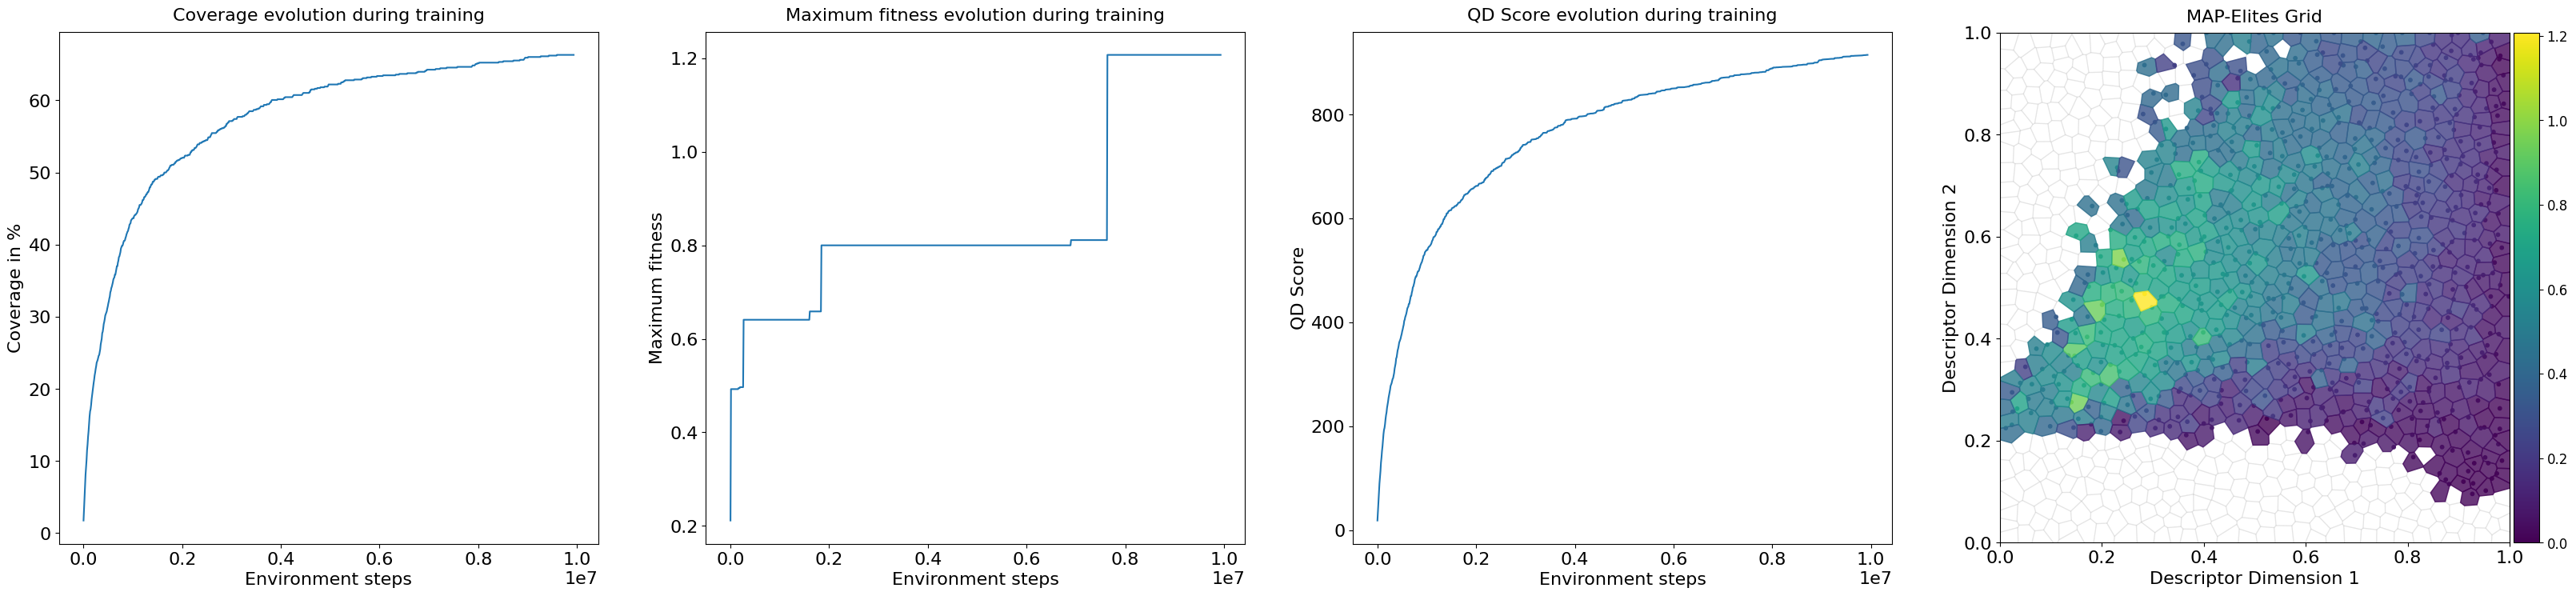

In [18]:
# Create the x-axis array
#env_steps = metrics["iteration"]
env_steps = metrics["iteration"] * batch_size * episode_length * config["NUM_ENVS"]
#print(jnp.max(env_steps))
#print(jnp.max(metrics["iteration"]))

%matplotlib inline
# Create the plots and the grid
fig, axes = plot_map_elites_results(env_steps=env_steps, metrics=metrics, repertoire=repertoire, min_descriptor=min_descriptor, max_descriptor=max_descriptor)

In [19]:
best_idx = jnp.argmax(repertoire.fitnesses)
best_fitness = jnp.max(repertoire.fitnesses)
best_descriptor = repertoire.descriptors[best_idx]
print(
    f"Best fitness in the repertoire: {best_fitness:.2f}\n",
    f"Descriptor of the best individual in the repertoire: {best_descriptor}\n",
    f"Index in the repertoire of this individual: {best_idx}\n"
)

Best fitness in the repertoire: 1.21
 Descriptor of the best individual in the repertoire: [0.28403363 0.48786336]
 Index in the repertoire of this individual: 712



In [20]:
# select the parameters of the best individual
my_params = jax.tree.map(
    lambda x: x[best_idx],
    repertoire.genotypes
)

In [ ]:
def preprocess_obs_with_id(obs_dict, env):
    """Simulate CTRolloutManager's preprocessing by adding one-hot agent IDs."""
    new_obs_dict = {}
    num_agents = len(env.agents)
    for i, agent in enumerate(env.agents):
        obs = obs_dict[agent].flatten()
        one_hot = jax.nn.one_hot(i, num_classes=num_agents)
        new_obs_dict[agent] = jnp.concatenate([obs, one_hot])
    return new_obs_dict


def visualize_recurrent_policy(trained_params, env, config):
    rng = jax.random.PRNGKey(config["SEED"])
    rng, reset_rng = jax.random.split(rng)
    #wrapped_env = CTRolloutManager(env, batch_size=1)

    # Create policy network
    #network = RNNQNetwork(
    #    action_dim=wrapped_env.max_action_space,
    #    hidden_dim=config["HIDDEN_SIZE"],
    #)
    network = RNNQNetwork(
        action_dim=env.action_space(env.agents[0]).n,
        hidden_dim=config["HIDDEN_SIZE"],
    )
    
    # Reset environment
    #obs, env_state = wrapped_env.batch_reset(reset_rng)
    obs, env_state = env.reset(reset_rng)
    #dones = {
    #    agent: jnp.zeros((1), dtype=bool)
    #    for agent in env.agents + ["__all__"]
    #}
    dones = {agent: jnp.array(False) for agent in env.agents}
    hstate = ScannedRNN.initialize_carry(
        config["HIDDEN_SIZE"], len(env.agents), 1
    )
    
    # Collect all environment states
    returns = {agent: 0.0 for agent in env.agents}
    state_seq = []
    max_steps = config["NUM_STEPS"]

    for step in range(max_steps):
        # Compute Q-values
        # Prepare inputs for network
        obs = preprocess_obs_with_id(obs, env)
        _obs = batchify(obs)         # (num_agents, obs_dim)
        _obs = _obs[:, None, :]                      # (num_agents, 1, obs_dim)

        #_dones = batchify(dones)    # (num_agents,)
        #_dones = _dones[:, None]                     # (num_agents, 1)
        _dones = jnp.stack([jnp.array([dones[agent]]) for agent in env.agents])  # shape (num_agents, 1)
        _dones = jnp.expand_dims(_dones, axis=-1)  # from (3, 1) to (3, 1, 1)

        #print("_obs.shape:", _obs.shape)
        #print("_dones.shape:", _dones.shape)
        #print("hstate.shape:", hstate.shape)

        #avail_actions = wrapped_env.get_valid_actions(env_state.env_state)
        avail_actions = env.get_avail_actions(env_state.env_state)
        avail_actions = batchify(avail_actions)

        #def apply_fn(h, o, d, a):
        #    return network.apply(trained_params, h, o, d, a)
        #hstate, logits = jax.vmap(apply_fn, in_axes=(0, 0, 0, 0))(
        #    hstate,
        #    _obs,
        #    _dones,
        #    avail_actions,
        #)
        #print("hstate.shape:", hstate.shape)
        
        rng, _rng = jax.random.split(rng)
        hstate, action, entropy= select_action(hstate, _obs, _dones, avail_actions, trained_params, _rng, deterministic=True)

        #hstate = hstate[:, None, :]  # Already in (num_agents, hidden_dim)
        #logits = logits.squeeze(axis=1)  # (num_agents, num_envs, num_actions) remove the time dim
        #print("q_vals.shape", q_vals.shape)
        
        actions = {}

        for i, agent in enumerate(env.agents):
            #avail_agent = avail_actions[agent][None, None, :]  # shape (1, 1, n_actions)
            #print("avail_agent.shape", avail_agent.shape)
            
            #unavail_actions = 1 - avail_agent  # shape (1, 1, n_actions)
            
            # Select Q-values for this agent only
            #logits_agent = logits[i][None, None, :]  # shape (1, 1, n_actions)
            #q_masked = q_agent - (unavail_actions * 1e10)

            #action = jnp.argmax(q_masked, axis=-1)  # shape (1, 1)
            #action = action.squeeze()               # scalar
            #print("action.shape", action.shape)

            # Wrap in array with batch dim
            #actions[agent] = int(action)    # shape (1,)
            actions[agent] = int(action[i].item())    # shape (1,)
        
        rng, rng_s = jax.random.split(rng)
        state_seq.append((rng_s, env_state.env_state, actions))

        # Step environment

        # Batch the actions dict
        # Original actions: {'ally_0': 4, 'ally_1': 4, 'ally_2': 4}
        #actions = {k: jnp.array([v]) for k, v in actions.items()}

        #obs, env_state, rewards, dones, infos = wrapped_env.batch_step(
        #    rng_s, env_state, actions
        #)
        obs, env_state, rewards, dones, infos = env.step(rng_s, env_state, actions)
        returns = {a: returns[a] + rewards[a] for a in env.agents}
        
        if dones["__all__"]:
            break

    # Visualization
    print("Returns:", returns)

    viz = SMAXVisualizer(env, state_seq)
    viz.animate(view=False, save_fname="trained_sd_sac_rnn.gif")

In [ ]:
scenario = map_name_to_scenario(config["MAP_NAME"])
env = HeuristicEnemySMAX(scenario=scenario, **config["ENV_KWARGS"])
env = SMAXLogWrapper(env)

visualize_recurrent_policy(my_params, env, config)

obs shape inside select_action: (5, 1, 132)
hstate shape inside select_action: (5, 1, 64)
dones shape inside select_action: (5, 1, 1)
avail_actions shape inside select_action: (5, 10)
actions shape inside select_action: (5, 1)
new_hstate shape inside select_action: (5, 1, 64)
entropy shape inside select_action: (5,)
obs shape inside select_action: (5, 1, 132)
hstate shape inside select_action: (5, 1, 64)
dones shape inside select_action: (5, 1, 1)
avail_actions shape inside select_action: (5, 10)
actions shape inside select_action: (5, 1)
new_hstate shape inside select_action: (5, 1, 64)
entropy shape inside select_action: (5,)
obs shape inside select_action: (5, 1, 132)
hstate shape inside select_action: (5, 1, 64)
dones shape inside select_action: (5, 1, 1)
avail_actions shape inside select_action: (5, 10)
actions shape inside select_action: (5, 1)
new_hstate shape inside select_action: (5, 1, 64)
entropy shape inside select_action: (5,)
obs shape inside select_action: (5, 1, 132)
hs